In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'https://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file and return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in the data hub."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'Downloading {url} to {fname}...')
    r = requests.get(url, stream=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """下载并解压zip/tar文件。"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩。'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件。"""
    for name in DATA_HUB:
        download(name)
    

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

# train_data = pd.read_csv(download('kaggle_house_train'))
# test_data = pd.read_csv(download('kaggle_house_test'))
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

print(train_data.shape)
print(test_data.shape)

(47439, 41)
(31626, 40)


In [3]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   

                                             Summary         City    Zip State  
0  540 Pine Ln, Los Altos, CA 94022 is a single f...    Los Altos  94022    CA  
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  Los Angeles  90047    CA  
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...   Strawberry  95375    CA  
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  Culver City  90230    CA  


In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [5]:
# 在标准化之前，先检查数据类型和唯一值分布
print("=== 数据概况 ===")
print(f"总行数: {len(all_features)}")
print(f"总列数: {len(all_features.columns)}")
print(f"\n数据类型统计：")
print(all_features.dtypes.value_counts())

# 检查每个分类列的唯一值数量
categorical_cols = all_features.select_dtypes(include=['object']).columns
print(f"\n分类列数: {len(categorical_cols)}")

if len(categorical_cols) > 0:
    print("\n每个分类列的唯一值数量：")
    for col in categorical_cols:
        n_unique = all_features[col].nunique()
        n_missing = all_features[col].isna().sum()
        print(f"  {col}: {n_unique} 个唯一值, {n_missing} 个缺失值")
        if n_unique > 50:
            print(f"    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！")

=== 数据概况 ===
总行数: 79065
总列数: 40

数据类型统计：
object     21
float64    18
int64       1
Name: count, dtype: int64

分类列数: 21

每个分类列的唯一值数量：
  Address: 78875 个唯一值, 0 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Summary: 77773 个唯一值, 846 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Type: 174 个唯一值, 0 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Heating: 2658 个唯一值, 12207 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Cooling: 909 个唯一值, 30144 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Parking: 9911 个唯一值, 2325 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Bedrooms: 277 个唯一值, 4598 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Region: 1258 个唯一值, 2 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Elementary School: 3567 个唯一值, 8493 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Middle School: 808 个唯一值, 28277 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  High School: 921 个唯一值, 7174 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Flooring: 1738 个唯一值, 21936 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Heating features: 1761 个唯一值, 13392 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Cooling features: 594 个唯一值, 32117 个缺失值
    ⚠️ 警告: 唯一值过多，可能导致内存爆炸！
  Appliances 

In [6]:
# 删除高基数分类特征（唯一值过多的列）和无用的文本列
# 这些列如果进行独热编码会导致内存爆炸
drop_cols = ['Address', 'Summary', 'Listed On', 'Last Sold On', 
             'Parking features', 'Appliances included', 'Parking',
             'Heating features', 'Cooling features', 'Laundry features',
             'Flooring', 'Elementary School', 'Middle School', 'High School']

# 只删除存在的列
drop_cols = [col for col in drop_cols if col in all_features.columns]
all_features = all_features.drop(columns=drop_cols)
print(f"删除 {len(drop_cols)} 个高基数特征后，剩余列数: {len(all_features.columns)}")

删除 14 个高基数特征后，剩余列数: 26


In [7]:
# 标准化数值特征
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print("数值特征标准化完成")

数值特征标准化完成


In [8]:
# 检查剩余的分类特征
remaining_categorical = all_features.select_dtypes(include=['object']).columns
print(f"剩余分类特征: {len(remaining_categorical)}")
for col in remaining_categorical:
    print(f"  {col}: {all_features[col].nunique()} 个唯一值")

# 对剩余分类特征进行独热编码
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=float)
print(f"\n独热编码后的特征维度: {all_features.shape}")

剩余分类特征: 7
  Type: 174 个唯一值
  Heating: 2658 个唯一值
  Cooling: 909 个唯一值
  Bedrooms: 277 个唯一值
  Region: 1258 个唯一值
  City: 1122 个唯一值
  State: 2 个唯一值

独热编码后的特征维度: (79065, 6426)


In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values.astype('float32'),
                              dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values.astype('float32'),
                             dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1),
                            dtype=torch.float32)
print(f"特征维度: {train_features.shape[1]}")
print(f"训练样本数: {train_features.shape[0]}")
print(f"测试样本数: {test_features.shape[0]}")

特征维度: 6426
训练样本数: 47439
测试样本数: 31626


In [10]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    # 更简单的网络结构，3层隐藏层
    h1 = 256   # 第一层
    h2 = 128   # 第二层  
    h3 = 64    # 第三层
    
    net = nn.Sequential(
        nn.Linear(in_features, h1),
        nn.ReLU(),
        nn.Dropout(0.3),
        
        nn.Linear(h1, h2),
        nn.ReLU(),
        nn.Dropout(0.2),
        
        nn.Linear(h2, h3),
        nn.ReLU(),
        nn.Dropout(0.1),
        
        nn.Linear(h3, 1)
    )
    
    # 使用Xavier初始化
    for layer in net:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    return net


In [11]:
# 对于相对误差较大的情况，我们使用对数均方根误差（log RMSE）作为评价指标。
def log_rmse(net, features, labels):
    with torch.no_grad():
        # To ensure that the logarithm function is well-defined, we clamp the predicted values to be at least 1.
        clipped_preds = torch.clamp(net(features), 1, float('inf'))
        rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    train_features, train_labels = train_features.to(device), train_labels.to(device)
    if test_features is not None:
        test_features, test_labels = test_features.to(device), test_labels.to(device)
    train_ls, test_ls = [], []
    train_iter = d2l.load_array(
        (train_features, train_labels), 
        batch_size
    )
    optimizer = torch.optim.Adam(
        net.parameters(), 
        lr=learning_rate,
        weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [13]:
def get_k_fold_data(k, i, X, y):
    """获取第i折交叉验证时所需要的训练和验证数据。"""
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [14]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold {i + 1}, train log rmse {float(train_ls[-1]):f}, '
              f'valid log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

开始 5 折交叉验证，每折 150 轮...
fold 1, train log rmse 0.095305, valid log rmse 0.142425
fold 2, train log rmse 0.099126, valid log rmse 0.137648
fold 3, train log rmse 0.093936, valid log rmse 0.154621
fold 4, train log rmse 0.091095, valid log rmse 0.161574
fold 5, train log rmse 0.092211, valid log rmse 0.647490
5-折验证: 平均训练log rmse: 0.094335, 平均验证log rmse: 0.248752


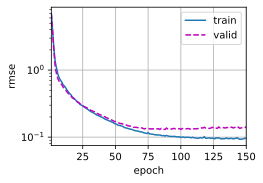

In [15]:
# 优化后的超参数：
# 1. 增加batch_size到512，提供更稳定的梯度估计
# 2. 学习率设为0.001
# 3. weight_decay设为0.02，加强L2正则化
# 4. 训练150轮
k, num_epochs, lr, weight_decay, batch_size = 5, 150, 0.001, 0.02, 512
print(f"开始 {k} 折交叉验证，每折 {num_epochs} 轮...")
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')


train log rmse 0.090474


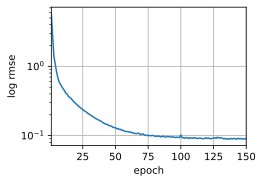

: 

In [ ]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'train log rmse {float(train_ls[-1]):f}')
    # 确保test_features与模型在同一设备上
    device = next(net.parameters()).device
    test_feature_device = test_feature.to(device)
    preds = net(test_feature_device).detach().cpu().numpy()
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)